In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from scipy.special import expit, logit
import os

from bids import BIDSLayout

import pymc as pm
import arviz as az

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

In [2]:
BIDS_ROOT = 'bids_dataset'

In [3]:
# prepare trial data for multilevel model
layout = BIDSLayout(BIDS_ROOT)
ev_files = layout.get(
    return_type = 'file', 
    suffix = 'events',
    extension = 'tsv'
)
events = []
for i, f in enumerate(ev_files):
    ev = pd.read_csv(f, sep = '\t')
    ev = ev[ev.trial_type.str.contains('random')]
    ev['subject'] = np.full(ev.shape[0], i)
    events.append(ev)
events = pd.concat(events)

In [4]:
n_sub = len(layout.get_subjects())
n_param = 4

model = pm.Model()
with model:
    
    # grouping variable
    sub = pm.Data('subject', events.subject.to_numpy())
    delay = pm.Data('delay', events.delay.to_numpy())
    post = pm.Data('post-adaption', (events.trial_type.to_numpy() == 'random2').astype(int))
    
    # priors for population-level parameters
    p0 = pm.Beta('p0', 1, 3) # probability of detection at zero delay
    b0 = pm.Deterministic('b0', pm.logit(p0)) # intercept
    b1 = pm.Exponential('b1', .1) # effect of delay, must be positive -- on scale of delay
    b2 = pm.Normal('b2', 0, 1) # effect of adaption -- unitless
    b3 = pm.Normal('b3', 0, 10) # interaction
    
    # multivariate normal distribution of subject-specific params (uncentered)
    z = pm.Normal("z", 0.0, 1.0, shape = (n_param, n_sub))
    chol, corr, stds = pm.LKJCholeskyCov( # correlation matrix
        "chol", 
        n = n_param, 
        eta = 2.0, 
        sd_dist = pm.Exponential.dist(1), 
        compute_corr = True
    )
    offsets = pm.math.dot(chol, z).T # MVNormal draws, n_sub x n_param
    b0_sub = pm.Deterministic('b0_sub', b0 + offsets[:, 0])
    b1_sub = pm.Deterministic('b1_sub', b1 + offsets[:, 1])
    b2_sub = pm.Deterministic('b2_sub', b2 + offsets[:, 2])
    b3_sub = pm.Deterministic('b3_sub', b3 + offsets[:, 3])
    
    # logistic regression model given subject-specific params
    theta = b0_sub[sub] + b1_sub[sub]*delay + b2_sub[sub]*post + b3_sub[sub]*post*delay
    p = pm.invlogit(theta)
    y = pm.Bernoulli('y', p, observed = events.detected_delay.to_numpy())

In [5]:
with model:
    trace = pm.sample(
        2500, 
        chains = 4,
        cores = 4,
        target_accept = 0.95,
        random_seed = 0,
        return_inferencedata = True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, b1, b2, b3, z, chol]


Output()

Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 606 seconds.


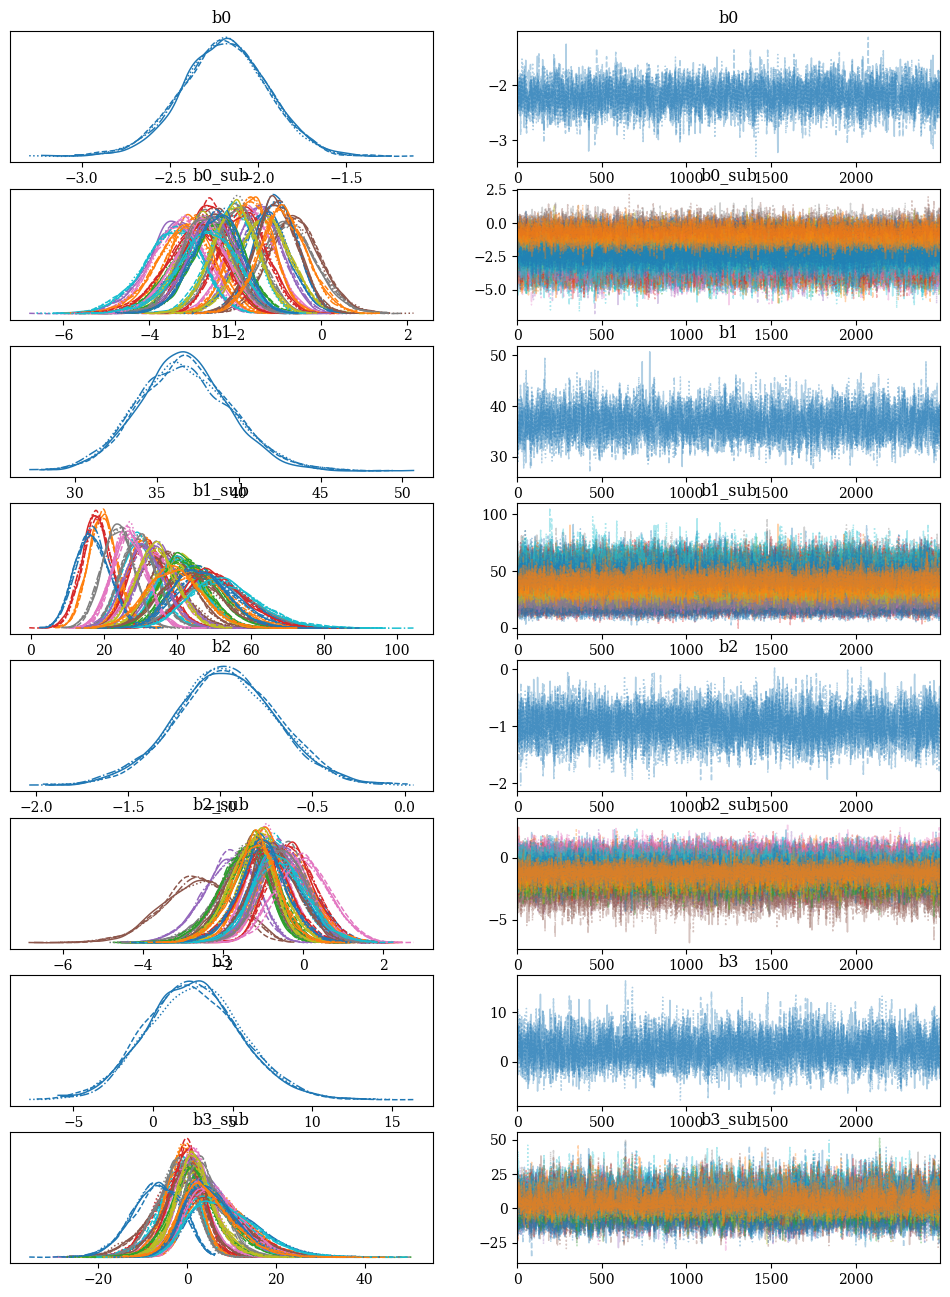

In [6]:
ax = az.plot_trace(trace, var_names = ['b0', 'b0_sub', 'b1', 'b1_sub', 'b2', 'b2_sub', 'b3', 'b3_sub'])

In [7]:
hdi_prob = .95
az.summary(trace, var_names = ['p0', 'b0', 'b1', 'b2', 'b3'], hdi_prob = hdi_prob)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,0.103,0.022,0.062,0.149,0.000,0.000,3847.0,5760.0,1.0
b0,-2.191,0.244,-2.665,-1.708,0.004,0.003,3847.0,5760.0,1.0
b1,36.695,2.850,31.153,42.317,0.047,0.033,3721.0,6389.0,1.0
b2,-0.972,0.277,-1.532,-0.430,0.004,0.003,4702.0,5352.0,1.0
b3,2.582,3.001,-3.056,8.625,0.050,0.035,3624.0,5813.0,1.0


In [8]:
# gather samples for population parameters 
trc = trace.posterior.stack(draws = ("chain", "draw"))
b0 = trc['b0'].values
b1 = trc['b1'].values
b2 = trc['b2'].values
b3 = trc['b3'].values

In [9]:
(b2 < 0).mean() # probability of adapation for population

0.9998

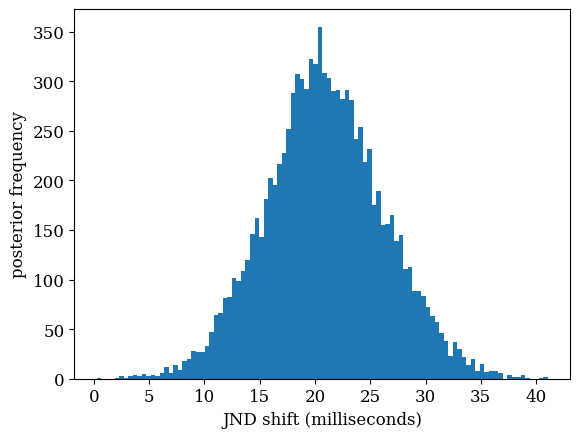

The point of 50% detection shifts from 59.8 ms to 80.7 ms or by 20.9 ms on average.
The 95.0% HDI of the shift is: (10.5 ms, 31.4 ms)


In [10]:
jnd1 = (logit(1/2) - b0)/(b1) * 1e3
jnd2 = (logit(1/2) - b0 - b2)/(b1 + b3) * 1e3
delta = jnd2 - jnd1
ax = plt.hist(delta, bins = 100)
plt.xlabel('JND shift (milliseconds)')
plt.ylabel('posterior frequency')
plt.show()
print('The point of 50% detection shifts from {:.1f} ms to {:.1f} ms '.format(jnd1.mean(), jnd2.mean()) + 
      'or by {:.1f} ms on average.'.format(delta.mean()))
hdi = az.hdi(delta, hdi_prob)
print('The {:.1f}% HDI of the shift is: ({:.1f} ms, {:.1f} ms)'.format(hdi_prob * 100, hdi[0], hdi[1]))

In [11]:
# get posterior for predicted probabilities
t_max = np.max(events.delay)
x = np.stack([np.linspace(0, t_max, 500) for i in range(b0.shape[0])], axis = 1)
p1 = expit(b0 + b1*x)
p2 = expit((b0 + b2) + (b1 + b3)*x)

/tmp/ipykernel_1047915/3055505671.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(p.T, .9)
/tmp/ipykernel_1047915/3055505671.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(p.T, .9)


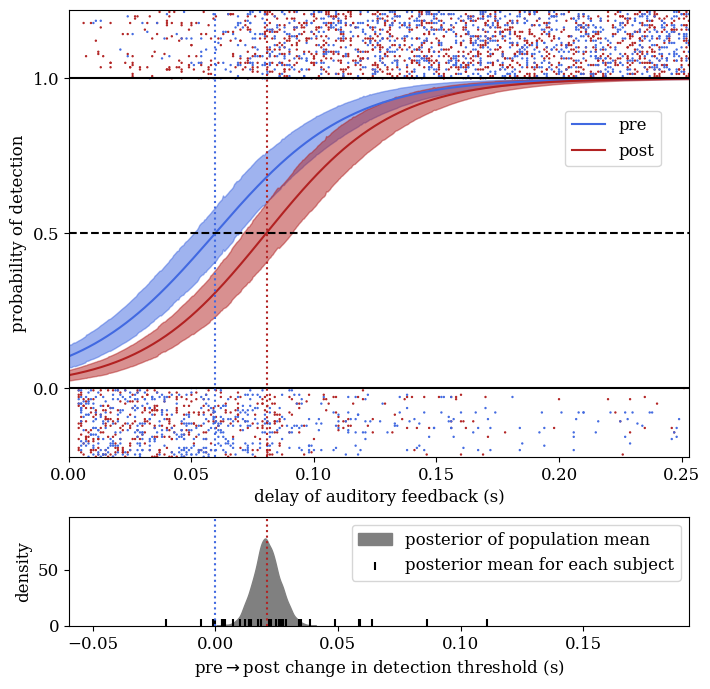

In [12]:
def plot_hdi(x, p, label, mean_col = 'royalblue', hdi_col = 'royalblue', ax = None):
    m = p.mean(1)
    hdi = az.hdi(p.T, .9)
    ax.fill_between(x[:,0], hdi[:,0], hdi[:,1], color = hdi_col, alpha = .5)
    ax.plot(x[:,0], m, color = mean_col, label = label)

fig = plt.figure(figsize = (8, 8))
gs = gridspec.GridSpec(4, 1, hspace = .55)
axs = [fig.add_subplot(gs[:3, 0]), fig.add_subplot(gs[-1, 0])]

plot_hdi(x, p1, 'pre', ax = axs[0]) # before adaption
plot_hdi(x, p2, 'post', 'firebrick', 'firebrick', ax = axs[0]) # after adaption
col = np.where(events.trial_type.to_numpy() == 'random2', 'royalblue', 'firebrick')
sub_off = 140
off = np.where(events.detected_delay.to_numpy(), 0, -1 * (n_sub - 1)/sub_off)
jitter = events.subject/sub_off + off # each subject gets their own row
axs[0].scatter(events.delay, events.detected_delay + jitter, color = col, s = .5)
axs[0].set_xlabel('delay of auditory feedback (s)')
axs[0].set_ylabel('probability of detection')
axs[0].legend(loc = (.8, .65))
axs[0].set_yticks([0., .5, 1.])
axs[0].axhline(0, color = 'black')
axs[0].axhline(1, color = 'black')
axs[0].axhline(.5, color = 'black', linestyle = '--')
axs[0].set_ylim(-jitter.max(), 1+jitter.max())

b0 = trc['b0'].values
b1 = trc['b1'].values
b2 = trc['b2'].values
b3 = trc['b3'].values
jnd1 = (logit(1/2) - b0)/(b1) 
jnd2 = (logit(1/2) - b0 - b2)/(b1 + b3) 
delta = jnd2 - jnd1

axs[0].set_xlim(0., t_max)
axs[1].set_xlim(-jnd1.mean(), t_max - jnd1.mean())
axs[0].axvline(jnd1.mean(), color = 'royalblue', linestyle = 'dotted')
axs[1].axvline(0, color = 'royalblue', linestyle = 'dotted')
axs[0].axvline(jnd2.mean(), color = 'firebrick', linestyle = 'dotted')
axs[1].axvline(delta.mean(), color = 'firebrick', linestyle = 'dotted')
grid, pdf = az.kde(delta)
axs[1].fill_between(
    grid, np.zeros_like(pdf), pdf, 
    color = 'grey', label = 'posterior of population mean'
)
axs[1].set_ylim(0, 1.25*pdf.max())
axs[1].set_xlabel(r'pre$\rightarrow$post change in detection threshold (s)')
axs[1].set_ylabel('density')

b0 = trc['b0_sub'].values
b1 = trc['b1_sub'].values
b2 = trc['b2_sub'].values
b3 = trc['b3_sub'].values
jnd1 = (logit(1/2) - b0)/(b1) 
jnd2 = (logit(1/2) - b0 - b2)/(b1 + b3) 
delta = jnd2 - jnd1
delta_sub = delta.mean(1)
axs[1].scatter(
    delta_sub, 2 + np.zeros_like(delta_sub), 
    marker = '|', color = 'black', 
    label = 'posterior mean for each subject'
)
axs[1].legend()

plt.savefig(os.path.join('figures', 'jnd.jpeg'), dpi = 500, bbox_inches = 'tight')
plt.show()

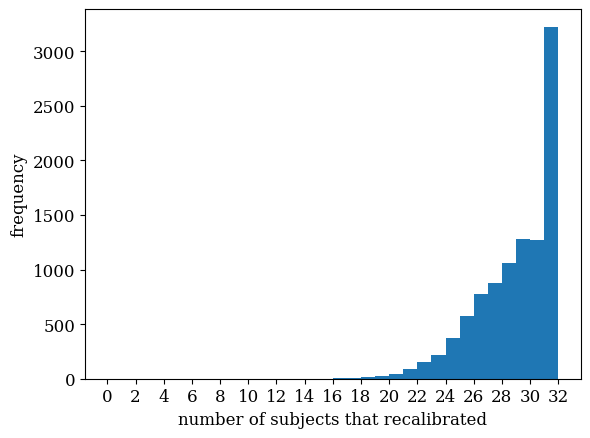

With probability 0.95, at least 23 out of 32 people recalibrated.


In [13]:
# how many subjects recalibrated?
b2_sub = trc['b2_sub'].values
n_recal = (b2_sub < 0).sum(axis = 0) # number of subjects who recalibrated in each posterior sample
plt.hist(n_recal, bins = n_sub, range = (0, n_sub))
plt.xticks([i for i in range(n_sub + 1) if i % 2 == 0])
plt.xlabel('number of subjects that recalibrated')
plt.ylabel('frequency')
plt.show()

recal_prob = .95
n_recal = np.percentile(n_recal, 100*(1 - recal_prob))
print(
    'With probability {:.2f}, at least {:.0f} out of {:.0f} people recalibrated.'.format(
        recal_prob, n_recal, n_sub
    )
)

In [14]:
n_recal = (b2_sub < 0).sum(axis = 0)
print(n_recal.mean(), az.hdi(n_recal, hdi_prob = .95))

28.625 [23 32]
